# Bilevel Markets
[![bilevel_markets.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/eduardosalaz/bilevel/bilevel_markets.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/eduardosalaz/bilevel/bilevel_markets.ipynb) [![Open In Deepnote](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?url=https://github.com/ampl/colab.ampl.com/blob/master/authors/eduardosalaz/bilevel/bilevel_markets.ipynb) [![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/eduardosalaz/bilevel/bilevel_markets.ipynb) [![Open In Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/eduardosalaz/bilevel/bilevel_markets.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/eduardosalaz/bilevel/bilevel_markets.ipynb) [![Powered by AMPL](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/eduardosalaz/bilevel/bilevel_markets.ipynb)](https://ampl.com)

Description: A notebook that presents a comprehensive mathematical formulation of strategic bidding in electricity markets using bilevel optimization and its equivalent single-level Mathematical Program with Equilibrium Constraints (MPEC) obtained through Karush-Kuhn-Tucker (KKT) transformation.

Tags: educational, bilevel, complementarity, amplpy, gurobi, knitro, baron, mpec, energy, Electric Power Industry

Notebook author: Eduardo Salazar <<eduardo@ampl.com>>

Model author: Eduardo Salazar <<eduardo@ampl.com>>

References:
1. Luo, Pang, Ralph (1996) "Mathematical Programs with Equilibrium Constraints": https://www.cambridge.org/core/books/mathematical-programs-with-equilibrium-constraints/03981C32ABDD55A4001BF58BA0C57444
2. Gabriel et al. (2013) "Complementarity Modeling in Energy Markets": https://link.springer.com/book/10.1007/978-1-4419-6123-5
3. Fortuny-Amat & McCarl (1981) "A Representation and Economic Interpretation of a Two-Level Programming Problem": https://www.jstor.org/stable/2581394

In [1]:
# Install dependencies
%pip install -q amplpy pandas matplotlib numpy

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi", "knitro", "baron"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Bilevel electricity markets problem
Electricity markets exhibit complex strategic interactions where large generators can influence market prices through their bidding behavior. This creates a bilevel optimization problem where:
- **Upper Level (Leader)**: Strategic generators choose their bid prices to maximize profit, anticipating how the market will respond
- **Lower Level (Follower)**: The ISO clears the market by dispatching generators to minimize total bid cost, given all submitted bids

The key challenge is that the strategic generator's profit depends on the market clearing price, which itself depends on all generators' bids in a complex, non-linear way. This interdependence makes the problem non-convex and computationally challenging, even when each level individually is convex.

### Key Insight: Bid vs. Cost

A critical distinction in this model:
- **Bid** ($\text{bid}_i$): What the generator *tells* the market it costs to produce
- **True Cost** ($c_i p_i + q_i p_i^2$): What it *actually* costs to produce
- **Profit**: Market price $\times$ quantity: True cost (not bid!)

The strategic generator bids above its cost to maximize profit, knowing that the ISO will dispatch based on bids, not actual costs.

The strategic generator (Coal) solves:
\begin{align}
\max_{bid_{\text{Coal}}} \quad & \lambda^* \cdot p_{\text{Coal}}^* - \underbrace{c_{\text{Coal}} \cdot p_{\text{Coal}}^* - q_{\text{Coal}} \cdot (p_{\text{Coal}}^*)^2}_{\text{true cost (not bid!)}} \\
\text{where} \quad & (p^*, \lambda^*) = \arg\min \text{ [Lower Level Problem given } bid_{\text{Coal}} \text{]}
\end{align}



Coal's **revenue** depends on market price $\lambda^*$ and its dispatch $p_{\text{Coal}}^*$


Coal's cost is based on true cost, not the bid

The gap between bid and true cost is where profit comes from

Coal must predict how the ISO will respond to its bid

Lower Level Problem (ISO Market Clearing)
Given the bids from all generators, the ISO solves:
\begin{align}
\min_{p_i} \quad & \underbrace{bid_{\text{Coal}} \cdot p_{\text{Coal}}}_{\text{strategic bid}} + \sum_{i \in \text{Competitive}} \underbrace{c_i \cdot p_i}_{\text{competitive bids}} \\
\text{s.t.} \quad & \sum_{i \in \text{All}} p_i = D \quad (\nu) \\
& 0 \leq p_i \leq \bar{p}_i \quad \forall i \quad (\mu_i^-, \mu_i^+)
\end{align}


ISO minimizes perceived cost based on submitted bids

ISO doesn't know Coal's true cost

Competitive generators bid their true marginal cost: $bid_i = c_i$

Numbers in parentheses ($\nu, \mu_i^-, \mu_i^+$) are dual variables (explained below)


## Notation and Sets

### Index Sets

| Symbol | Description |
|--------|-------------|
| $\mathcal{G}$ | Set of all generators (indexed by $i$) |
| $\mathcal{S} \subseteq \mathcal{G}$ | Strategic generators (Stackelberg leaders) |
| $\mathcal{C} \subseteq \mathcal{G}$ | Competitive generators (price-takers) |

**Note:** $\mathcal{S} \cap \mathcal{C} = \emptyset$ and $\mathcal{S} \cup \mathcal{C} = \mathcal{G}$.

### Parameters

| Symbol | Description | Units |
|--------|-------------|-------|
| $D$ | Total system demand | MW |
| $c_i$ | True marginal cost of generator $i$ | \$/MWh |
| $q_i$ | Quadratic cost coefficient | \$/MW²h |
| $\bar{p}_i$ | Capacity limit of generator $i$ | MW |

The total cost for generator $i$ to produce $p_i$ MW is: $C_i(p_i) = c_i p_i + q_i p_i^2$.

### Decision Variables

| Symbol | Description | Level | Units |
|--------|-------------|-------|-------|
| $\text{bid}_i$ | Bid price for generator $i \in \mathcal{S}$ | Upper | \$/MWh |
| $p_i$ | Generation dispatch for $i \in \mathcal{G}$ | Lower | MW |
| $\lambda$ | Market clearing price (LMP) | Lower | \$/MWh |

### Dual Variables (for Lower Level)

| Symbol | Description | Units |
|--------|-------------|-------|
| $\nu$ | Dual of power balance constraint | \$/MWh |
| $\mu_i^-$ | Dual of lower bound $p_i \geq 0$ | \$/MW |
| $\mu_i^+$ | Dual of upper bound $p_i \leq \bar{p}_i$ | \$/MW |

---

## Original Bilevel Formulation

### Complete Mathematical Model

#### Upper Level Problem (Strategic Generator)

$$
\begin{align}
\max_{\text{bid}_i, \, i \in \mathcal{S}} \quad & \sum_{i \in \mathcal{S}} \left( \lambda \cdot p_i - c_i \cdot p_i - q_i \cdot p_i^2 \right) \tag{UL-Obj}\\
\text{subject to} \quad & \text{bid}_i \geq c_i, \quad \forall i \in \mathcal{S} \tag{UL-1}\\
& (p^*, \lambda^*) \in \arg\min \text{ (Lower Level Problem)} \tag{UL-2}
\end{align}
$$

#### Lower Level Problem (Market Clearing by ISO)

Given bids $\{\text{bid}_i\}_{i \in \mathcal{S}}$ from strategic generators:

$$
\begin{align}
\min_{p_i, \, i \in \mathcal{G}} \quad & \sum_{i \in \mathcal{S}} \text{bid}_i \cdot p_i + \sum_{i \in \mathcal{C}} c_i \cdot p_i \tag{LL-Obj}\\
\text{subject to} \quad & \sum_{i \in \mathcal{G}} p_i = D \tag{LL-1} \quad [\nu]\\
& 0 \leq p_i \leq \bar{p}_i, \quad \forall i \in \mathcal{G} \tag{LL-2} \quad [\mu_i^-, \mu_i^+]
\end{align}
$$

#### Market Price Definition

The market clearing price is defined as:

$$
\lambda = \nu \tag{Price}
$$

where $\nu$ is the dual variable (shadow price) of the power balance constraint (LL-1).

### Economic Interpretation

#### Upper Level Objective (UL-Obj)

The strategic generator's profit has two components:

- **Revenue**: $\lambda \cdot p_i$ — the market clearing price times the quantity sold
- **Cost**: $c_i \cdot p_i + q_i \cdot p_i^2$ — the *actual* cost of production

**Key Point:** The generator pays its *true cost* to produce power, not the bid. The bid only affects how much power it gets dispatched and what market price emerges.

#### Lower Level Objective (LL-Obj)

The ISO minimizes total *bid cost*, not actual cost:

- Strategic generators are dispatched based on their **bids** ($\text{bid}_i$)
- Competitive generators are dispatched based on their **true costs** ($c_i$)

This is realistic: the ISO only knows what generators bid, not their actual costs.

#### Power Balance (LL-1)

Supply must equal demand exactly:

$$
\sum_{i \in \mathcal{G}} p_i = D
$$

The dual variable $\nu$ represents the marginal cost of serving one additional MW of demand — this is the **Locational Marginal Price (LMP)**.

#### Strategic Behavior

The strategic generator faces a fundamental tradeoff:

- **Higher bid** ⇒ Higher market price $\lambda$ (if dispatched) BUT lower dispatch quantity $p_i$
- **Lower bid** ⇒ Higher dispatch quantity BUT lower market price

The optimal bid balances these competing effects to maximize profit.

### Why This is a Bilevel Problem

The challenge is that constraint (UL-2) is an *optimization problem*, not a simple algebraic constraint. The upper level must find:

$$
\text{bid}_i \in \arg\max_{\text{bid}} \left\{ \lambda(\text{bid}) \cdot p(\text{bid}) - c_i \cdot p(\text{bid}) - q_i \cdot p(\text{bid})^2 \right\}
$$

where $p(\text{bid})$ and $\lambda(\text{bid})$ are *implicitly* defined by the solution to the lower level problem. This implicit dependence is what makes bilevel problems difficult.

## KKT-Transformed MPEC Formulation

To solve the bilevel problem, we replace the lower level optimization (LL-Obj)–(LL-2) with its Karush-Kuhn-Tucker (KKT) necessary optimality conditions. This transforms the problem into a single-level Mathematical Program with Equilibrium Constraints (MPEC).

### Complete MPEC Formulation

#### Objective Function

$$
\begin{align}
\max_{\substack{\text{bid}_i, p_i, \lambda \\ \mu_i^-, \mu_i^+, \nu}} \quad \sum_{i \in \mathcal{S}} \left( \lambda \cdot p_i - c_i \cdot p_i - q_i \cdot p_i^2 \right) \tag{MPEC-Obj}
\end{align}
$$

#### Constraints

**Primal Feasibility (Lower Level Constraints)**

$$
\begin{align}
& \sum_{i \in \mathcal{G}} p_i = D \tag{PF-1}\\
& 0 \leq p_i \leq \bar{p}_i, \quad \forall i \in \mathcal{G} \tag{PF-2}
\end{align}
$$

**Dual Feasibility**

$$
\begin{align}
& \mu_i^- \geq 0, \quad \forall i \in \mathcal{G} \tag{DF-1}\\
& \mu_i^+ \geq 0, \quad \forall i \in \mathcal{G} \tag{DF-2}\\
& \nu \in \mathbb{R} \text{ (free)} \tag{DF-3}
\end{align}
$$

**Stationarity (Gradient of Lagrangian = 0)**

For strategic generators ($i \in \mathcal{S}$):

$$
\frac{\partial \mathcal{L}}{\partial p_i}: \quad \text{bid}_i - \nu - \mu_i^- + \mu_i^+ = 0 \tag{Stat-S}
$$

For competitive generators ($i \in \mathcal{C}$):

$$
\frac{\partial \mathcal{L}}{\partial p_i}: \quad c_i - \nu - \mu_i^- + \mu_i^+ = 0 \tag{Stat-C}
$$

**Complementarity Slackness**

$$
\begin{align}
& 0 \leq \mu_i^- \perp p_i \geq 0, \quad \forall i \in \mathcal{G} \tag{Comp-1}\\
& 0 \leq \mu_i^+ \perp (\bar{p}_i - p_i) \geq 0, \quad \forall i \in \mathcal{G} \tag{Comp-2}
\end{align}
$$

**Market Price Definition**

$$
\lambda = \nu \tag{Price-Def}
$$

**Upper Level Constraint**

$$
\text{bid}_i \geq c_i, \quad \forall i \in \mathcal{S} \tag{Bid-Bound}
$$

---

### Derivation of KKT Conditions

#### Step 1: Formulate the Lagrangian

The lower level problem (LL-Obj)–(LL-2) can be written in standard form:

$$
\begin{align}
\min_{p} \quad & \sum_{i \in \mathcal{S}} \text{bid}_i \cdot p_i + \sum_{i \in \mathcal{C}} c_i \cdot p_i\\
\text{subject to} \quad & h(p) = \sum_{i \in \mathcal{G}} p_i - D = 0\\
& g_i^-(p) = -p_i \leq 0, \quad \forall i \in \mathcal{G}\\
& g_i^+(p) = p_i - \bar{p}_i \leq 0, \quad \forall i \in \mathcal{G}
\end{align}
$$

The Lagrangian is:

$$
\begin{align}
\mathcal{L}(p, \nu, \mu^-, \mu^+) = &\sum_{i \in \mathcal{S}} \text{bid}_i \cdot p_i + \sum_{i \in \mathcal{C}} c_i \cdot p_i \\
&- \nu \left(\sum_{i \in \mathcal{G}} p_i - D\right) \\
&- \sum_{i \in \mathcal{G}} \mu_i^- (-p_i) - \sum_{i \in \mathcal{G}} \mu_i^+ (p_i - \bar{p}_i)
\end{align}
$$

Simplifying:

$$
\begin{align}
\mathcal{L}(p, \nu, \mu^-, \mu^+) = &\sum_{i \in \mathcal{S}} \text{bid}_i \cdot p_i + \sum_{i \in \mathcal{C}} c_i \cdot p_i \\
&- \nu \sum_{i \in \mathcal{G}} p_i + \nu D \\
&+ \sum_{i \in \mathcal{G}} \mu_i^- p_i - \sum_{i \in \mathcal{G}} \mu_i^+ p_i + \sum_{i \in \mathcal{G}} \mu_i^+ \bar{p}_i
\end{align}
$$

#### Step 2: Derive Stationarity Conditions

Taking the partial derivative with respect to $p_i$ for $i \in \mathcal{S}$:

$$
\frac{\partial \mathcal{L}}{\partial p_i} = \text{bid}_i - \nu + \mu_i^- - \mu_i^+ = 0
$$

Rearranging:

$$
\text{bid}_i = \nu + \mu_i^+ - \mu_i^- \quad \text{or} \quad \text{bid}_i - \nu - \mu_i^- + \mu_i^+ = 0
$$

Similarly for $i \in \mathcal{C}$:

$$
c_i = \nu + \mu_i^+ - \mu_i^-
$$

#### Step 3: Understanding Complementarity

The complementarity condition (Comp-1) means:

$$
\mu_i^- \cdot p_i = 0 \quad \text{with} \quad \mu_i^- \geq 0, \, p_i \geq 0
$$

This defines **mutually exclusive cases**:

1. If $p_i > 0$ (generator is dispatched), then $\mu_i^- = 0$
2. If $\mu_i^- > 0$ (lower bound is binding), then $p_i = 0$
3. Both can be zero simultaneously (degenerate case)

Similarly for (Comp-2):

1. If $p_i < \bar{p}_i$ (not at capacity), then $\mu_i^+ = 0$
2. If $\mu_i^+ > 0$ (at capacity), then $p_i = \bar{p}_i$

---

### Economic Interpretation of KKT Conditions

#### Stationarity: Marginal Pricing

From equation (Stat-S), when both $\mu_i^- = 0$ and $\mu_i^+ = 0$ (interior solution):

$$
\text{bid}_i = \nu = \lambda
$$

This is the **marginal generator** — the generator whose bid sets the market price.

- If $\text{bid}_i < \lambda$: Generator produces at capacity ($p_i = \bar{p}_i$, $\mu_i^+ > 0$), earning infra-marginal rent
- If $\text{bid}_i = \lambda$: Marginal generator, may produce anywhere in $[0, \bar{p}_i]$
- If $\text{bid}_i > \lambda$: Generator doesn't produce ($p_i = 0$, $\mu_i^- > 0$)

#### Dual Variables as Shadow Prices

| Dual | Economic Meaning |
|------|------------------|
| $\nu$ | **Locational Marginal Price (LMP):** Cost to serve one additional MW of demand |
| $\mu_i^-$ | **Startup value:** How much we'd gain if we could dispatch generator $i$ (when $p_i = 0$) |
| $\mu_i^+$ | **Capacity constraint shadow price:** How much we'd gain from one more MW of capacity at generator $i$ (when $p_i = \bar{p}_i$) |

#### Why $\lambda = \nu$?

The dual variable $\nu$ is the shadow price of the power balance constraint:

$$
\nu = \frac{\partial (\text{Total Bid Cost})}{\partial D}
$$

This is exactly the market clearing price: the marginal cost to serve one more unit of demand.

---

### Why Complementarity Creates Non-Convexity

Consider the feasible set defined by:

$$
\mu_i^- \geq 0, \quad p_i \geq 0, \quad \mu_i^- \cdot p_i = 0
$$

This is the **union** of two convex sets:

1. $\{(\mu_i^-, p_i) : \mu_i^- = 0, \, p_i \geq 0\}$ — generator is on
2. $\{(\mu_i^-, p_i) : \mu_i^- \geq 0, \, p_i = 0\}$ — generator is off

The union of convex sets is **not convex**. This is why MPEC problems are non-convex even when both levels are convex individually.

**Remark:** The complementarity condition represents a **regime switch**: the generator is either producing ($p_i > 0$) or not producing ($p_i = 0$). The optimization must implicitly decide which regime each generator is in, leading to a combinatorial explosion of possibilities.

---

### Worked Example: Three-Generator System

Consider a simple system to see how the conditions work:

| Generator | Type | Cost $c_i$ | Capacity $\bar{p}_i$ | Bid |
|-----------|------|------------|---------------------|-----|
| Coal | Strategic | \$10/MWh | 50 MW | **Decision variable** |
| Gas | Competitive | \$15/MWh | 40 MW | \$15/MWh |
| Peaker | Competitive | \$25/MWh | 30 MW | \$25/MWh |

Suppose demand $D = 100$ MW and the optimal solution is:
- Coal bids \$20/MWh and produces 50 MW (at capacity)
- Gas produces 40 MW (at capacity)
- Peaker produces 10 MW (interior)

#### Verification of KKT Conditions

**Power Balance (PF-1):** $50 + 40 + 10 = 100$ ✓

**Stationarity:**

For Coal (strategic, at capacity):
$$
20 - \nu - 0 + \mu_{\text{Coal}}^+ = 0 \implies \mu_{\text{Coal}}^+ = \nu - 20
$$

For Peaker (competitive, interior):
$$
25 - \nu - 0 + 0 = 0 \implies \nu = 25
$$

Therefore: $\mu_{\text{Coal}}^+ = 25 - 20 = 5$ (shadow value of Coal's capacity constraint)

**Market Price:** $\lambda = \nu = \$25$/MWh (set by Peaker's bid)

**Complementarity:**
- Coal: $p_{\text{Coal}} = 50 = \bar{p}_{\text{Coal}}$ ✓ and $\mu_{\text{Coal}}^+ = 5 > 0$ ✓
- Peaker: $0 < p_{\text{Peaker}} = 10 < 30$ ✓ so $\mu_{\text{Peaker}}^- = \mu_{\text{Peaker}}^+ = 0$ ✓

**Coal's Profit:**
$$
\text{Profit} = \lambda \cdot p - c \cdot p = 25(50) - 10(50) = \$750
$$


If Coal had bid its true cost (`$10/MWh`), it would still produce 50 MW, but the market price would be `$25/MWh` (set by Peaker), earning only `$750`. By bidding `$20/MWh`, Coal remains dispatched and maintains the high market price.

---

### Connection to AMPL Implementation

The MPEC formulation maps directly to AMPL code:

| **Mathematical Condition** | **AMPL Code** |
|---------------------------|---------------|
| Primal feasibility (PF-1) | `subject to PowerBalance: sum{i in GENERATORS} p[i] = demand;` |
| Stationarity (Stat-S) | `subject to Stationarity_Strategic {i in STRATEGIC}: bid[i] - nu - mu_lower[i] + mu_upper[i] = 0;` |
| Stationarity (Stat-C) | `subject to Stationarity_Competitive {i in COMPETITIVE}: c[i] - nu - mu_lower[i] + mu_upper[i] = 0;` |
| Complementarity (Comp-1) | `subject to Comp_Lower {i in GENERATORS}: mu_lower[i] >= 0 complements p[i] >= 0;` |
| Complementarity (Comp-2) | `subject to Comp_Upper {i in GENERATORS}: mu_upper[i] >= 0 complements pmax[i] - p[i] >= 0;` |
| Price definition (Price-Def) | `subject to Price_Definition: lambda = nu;` |
| Bid lower bound (Bid-Bound) | `subject to Bid_Lower_Bound {i in STRATEGIC}: bid[i] >= c[i];` |

**Key AMPL Feature:** The `complements` keyword automatically handles the disjunctive complementarity constraints using Knitro's MPEC algorithm. Without specialized solvers, these constraints would require mixed-integer reformulations.

---

### Why the KKT Transformation is Valid

The transformation from bilevel to MPEC is valid because:

1. **Lower level is convex:** Linear objective with linear constraints
2. **Constraint qualification holds:** Slater's condition (feasible interior exists)
3. **KKT conditions are necessary and sufficient** for convex problems

Therefore, replacing "$(p^*, \lambda^*)$ solves the lower level" with "KKT conditions hold" is an exact reformulation, not an approximation.

**Warning:** For non-convex lower levels, KKT conditions are only necessary, not sufficient. This can lead to incorrect solutions where the upper level exploits non-global optima of the lower level.

---

### Computational Complexity

Even with the single-level reformulation, MPEC problems are:

- **NP-hard** in general (due to complementarity)
- **Non-convex** (feasible region is a union of polyhedra)
- **Multiple local optima** possible (need global optimization or good initialization)

Specialized MPEC solvers like Knitro use:
- **Relaxation schemes** to temporarily ignore complementarity
- **Sequential approaches** that gradually enforce complementarity
- **Active set strategies** to identify which constraints are binding

In [4]:
%%writefile bilevel_market.mod
# ===========================================================================
# bilevel_market.mod
# Bilevel Electricity Market Model - MPEC Formulation
# ===========================================================================
# Upper Level: Strategic generator maximizes profit by choosing bid
# Lower Level: ISO minimizes cost given all bids (market clearing)
# ===========================================================================
reset;

# Sets
set GENERATORS;                        # All generators
set STRATEGIC within GENERATORS;       # Generators bidding strategically
set COMPETITIVE within GENERATORS;     # Generators bidding at cost

# Parameters
param demand >= 0;                     # Total demand (MW)
param c {GENERATORS} >= 0;             # True marginal cost ($/MWh)
param q {GENERATORS} >= 0;             # Quadratic cost coefficient
param pmax {GENERATORS} >= 0;          # Capacity limit (MW)
param VOLL default 30;               # Value of Lost Load ($/MWh) - typical bid cap
param PRICE_FLOOR default 0;           # Minimum price ($/MWh)

# Variables
var p {i in GENERATORS} >= 0, <= pmax[i];  # Generation dispatch (MW)
# Primal Feasibility - Inequality constraints (in variable bounds)
var lambda >= PRICE_FLOOR, <= VOLL;         # Market price bounded by floor and VOLL
var bid {i in STRATEGIC} >= 0, <= VOLL;     # Bids can't exceed market cap

# Dual variables with practical bounds
var mu_lower {GENERATORS} >= 0, <= VOLL;    # Shadow price of lower bound
var mu_upper {GENERATORS} >= 0, <= VOLL;    # Shadow price of upper bound
var nu >= -VOLL, <= VOLL;           # Dual of power balance = price
# No bounds = free = dual feasibility for equality constraint

# ===========================================================================
# Upper Level: Strategic Generator Profit Maximization
# ===========================================================================

# Objective: Maximize strategic generator's profit
# Revenue = price * quantity
# Cost = true cost (not bid!)
maximize StrategicProfit:
    sum {i in STRATEGIC} (lambda * p[i] - c[i] * p[i] - q[i] * p[i]^2);

# ===========================================================================
# Lower Level Constraints (Market Clearing) - As KKT Conditions
# ===========================================================================

# Power balance: supply = demand
subject to PowerBalance:
    sum {i in GENERATORS} p[i] = demand;

# ===========================================================================
# KKT Conditions for Lower Level (ISO's Market Clearing Problem)
# ===========================================================================
# Lower level problem is:
#   min  sum{i in STRATEGIC} bid[i]*p[i] + sum{i in COMPETITIVE} c[i]*p[i]
#   s.t. sum{i} p[i] = demand
#        0 <= p[i] <= pmax[i]
# ===========================================================================

# Stationarity: Gradient of Lagrangian = 0
# For strategic generators (bid is variable in upper level)
subject to Stationarity_Strategic {i in STRATEGIC}:
    bid[i] - nu - mu_lower[i] + mu_upper[i] = 0;

# For competitive generators (bid = cost, fixed)
subject to Stationarity_Competitive {i in COMPETITIVE}:
    c[i] - nu - mu_lower[i] + mu_upper[i] = 0;

# Complementarity: mu_lower[i] * p[i] = 0
# Dual feasibility for lower bound duals (embedded in complementarity)
subject to Comp_Lower {i in GENERATORS}:
    mu_lower[i] >= 0 complements p[i] >= 0;
    # ^^^^^^^^^^^ This part is dual feasibility

# Complementarity: mu_upper[i] * (pmax[i] - p[i]) = 0
# Dual feasibility for upper bound duals (embedded in complementarity)
subject to Comp_Upper {i in GENERATORS}:
    mu_upper[i] >= 0 complements pmax[i] - p[i] >= 0;
    # ^^^^^^^^^^^ This part is dual feasibility

# Market clearing price equals dual of power balance
subject to Price_Definition:
    lambda = nu;

# Optional: Logical constraint - bid should be at least cost
# (Can be relaxed if testing predatory pricing)
subject to Bid_Lower_Bound {i in STRATEGIC}:
    bid[i] >= c[i];

Overwriting bilevel_market.mod


The complements syntax in AMPL is doing double duty:

The` mu_lower[i] >= 0` part enforces Dual Feasibility


The `complements p[i] >= 0` part enforces Complementarity Slackness

So Comp_Lower and Comp_Upper actually encode both conditions 2 and 4!


This is why MPEC formulations in AMPL are so concise - the complementarity constraint captures two KKT conditions at once.

In [5]:
# @title


def solve_with_solver(ampl_instance, solver_name, solver_options=None, verbose=False):
    """
    Solve the MPEC problem with a specified solver

    Parameters:
    -----------
    ampl_instance : AMPL object
    solver_name : str - 'baron', 'knitro', or 'gurobi'
    solver_options : str - solver-specific options
    verbose : bool - whether to print detailed output

    Returns:
    --------
    dict with solution details
    """
    if verbose:
        print(f"\n{'='*70}")
        print(f"SOLVING WITH {solver_name.upper()}")
        print(f"{'='*70}")

    # Configure solver
    ampl_instance.option["solver"] = solver_name

    if solver_options:
        ampl_instance.option[f"{solver_name}_options"] = solver_options

    # Solve
    ampl_instance.option["reset_initial_guesses"] = 1
    # Don't send info of solution to other solvers
    result = ampl_instance.solve()

    # Extract results
    solve_result = ampl_instance.get_value("solve_result")
    solve_time = ampl_instance.get_value("_total_solve_time")

    # Get objective value
    try:
        objective = ampl_instance.obj["StrategicProfit"].value()
    except:
        objective = None

    # Get market price
    try:
        market_price = ampl_instance.var["lambda"].value()
    except:
        market_price = None

    # Get dispatch values
    generators = list(ampl_instance.set["GENERATORS"])
    dispatch = {}
    bids = {}

    for gen in generators:
        try:
            dispatch[gen] = ampl_instance.var["p"][gen].value()
        except:
            dispatch[gen] = None

        if gen in ampl_instance.set["STRATEGIC"]:
            try:
                bids[gen] = ampl_instance.var["bid"][gen].value()
            except:
                bids[gen] = None

    solution = {
        "solver": solver_name,
        "solve_result": solve_result,
        "solve_time": solve_time,
        "objective": objective,
        "market_price": market_price,
        "dispatch": dispatch,
        "bids": bids,
    }

    if verbose:
        print(f"\nSolve Result: {solve_result}")
        print(f"Solve Time: {solve_time:.3f} seconds")

        if objective is not None:
            print(f"Strategic Profit: ${objective:.2f}")
        if market_price is not None:
            print(f"Market Price: ${market_price:.2f}/MWh")

    return solution


def compare_solutions(solutions, gen_data):
    """
    Create a comparison table of all solver results
    """
    print(f"\n{'='*70}")
    print("SOLVER COMPARISON SUMMARY")
    print(f"{'='*70}\n")

    # Create comparison dataframe
    comparison_data = []

    for sol in solutions:
        row = {
            "Solver": sol["solver"].upper(),
            "Status": sol["solve_result"],
            "Time (s)": f"{sol['solve_time']:.3f}",
            "Profit ($)": f"{sol['objective']:.2f}" if sol["objective"] else "N/A",
            "Price ($/MWh)": (
                f"{sol['market_price']:.2f}" if sol["market_price"] else "N/A"
            ),
        }

        # Add dispatch for each generator
        for gen in sol["dispatch"].keys():
            dispatch_val = sol["dispatch"][gen]
            row[f"{gen} Dispatch (MW)"] = (
                f"{dispatch_val:.2f}" if dispatch_val else "N/A"
            )

        # Add bids for strategic generators
        for gen in sol["bids"].keys():
            bid_val = sol["bids"][gen]
            row[f"{gen} Bid ($/MWh)"] = f"{bid_val:.2f}" if bid_val else "N/A"

        comparison_data.append(row)

    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))

    # Check if solutions differ (indicating local optima)
    print(f"\n{'='*70}")
    print("LOCAL VS GLOBAL SOLVER ANALYSIS")
    print(f"{'='*70}\n")

    objectives = [s["objective"] for s in solutions if s["objective"] is not None]

    if len(objectives) > 1:
        max_obj = max(objectives)
        min_obj = min(objectives)

        print(f"Best objective found: ${max_obj:.2f}")
        print(f"Worst objective found: ${min_obj:.2f}")
        print(f"Difference: ${max_obj - min_obj:.2f}")

        if abs(max_obj - min_obj) > 0.01:  # Significant difference
            print("\nDIFFERENT SOLUTIONS FOUND!")
            print("This demonstrates that local solvers (Knitro) may find")
            print(
                "different local optima, while BARON (and Gurobi!) searches for global optimum."
            )

            # Identify which solver found the best solution
            best_solver = [s["solver"] for s in solutions if s["objective"] == max_obj][
                0
            ]
            print(f"\nBest solution found by: {best_solver.upper()}")
        else:
            print("\nAll solvers converged to the same solution (within tolerance)")

    return df_comparison


def visualize_comparison(solutions, gen_data, demand):
    """
    Create visualization comparing solver results
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(
        "Solver Comparison: BARON vs Knitro vs Gurobi", fontsize=16, fontweight="bold"
    )

    # Extract data for plotting
    generators = list(solutions[0]["dispatch"].keys())
    n_solvers = len(solutions)

    # Plot 1: Objective values
    ax1 = axes[0, 0]
    solver_names = [s["solver"].upper() for s in solutions]
    objectives = [s["objective"] if s["objective"] else 0 for s in solutions]
    colors_obj = ["#27ae60" if s["solver"] == "baron" else "#e74c3c" for s in solutions]

    bars = ax1.bar(
        solver_names, objectives, color=colors_obj, alpha=0.7, edgecolor="black"
    )
    ax1.set_ylabel("Strategic Profit ($)", fontsize=11)
    ax1.set_title("Objective Value Comparison", fontsize=12, fontweight="bold")
    ax1.grid(axis="y", alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"${height:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    # Plot 2: Market prices
    ax2 = axes[0, 1]
    prices = [s["market_price"] if s["market_price"] else 0 for s in solutions]
    bars = ax2.bar(solver_names, prices, color="#3498db", alpha=0.7, edgecolor="black")
    ax2.set_ylabel("Price ($/MWh)", fontsize=11)
    ax2.set_title("Market Clearing Price Comparison", fontsize=12, fontweight="bold")
    ax2.grid(axis="y", alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"${height:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    # Plot 3: Dispatch comparison
    ax3 = axes[1, 0]
    x = np.arange(len(generators))
    width = 0.25

    for i, sol in enumerate(solutions):
        dispatch_vals = [
            sol["dispatch"][g] if sol["dispatch"][g] else 0 for g in generators
        ]
        offset = width * (i - 1)
        ax3.bar(
            x + offset,
            dispatch_vals,
            width,
            label=sol["solver"].upper(),
            alpha=0.7,
            edgecolor="black",
        )

    ax3.set_ylabel("Dispatch (MW)", fontsize=11)
    ax3.set_title("Generation Dispatch Comparison", fontsize=12, fontweight="bold")
    ax3.set_xticks(x)
    ax3.set_xticklabels(generators)
    ax3.legend()
    ax3.grid(axis="y", alpha=0.3)

    # Plot 4: Strategic bids comparison
    ax4 = axes[1, 1]
    strategic_gens = [g for g in generators if any(g in s["bids"] for s in solutions)]

    if strategic_gens:
        x = np.arange(len(strategic_gens))

        for i, sol in enumerate(solutions):
            bid_vals = [
                sol["bids"].get(g, 0) if sol["bids"].get(g) else 0
                for g in strategic_gens
            ]
            offset = width * (i - 1)
            ax4.bar(
                x + offset,
                bid_vals,
                width,
                label=sol["solver"].upper(),
                alpha=0.7,
                edgecolor="black",
            )

        # Add true costs as reference
        true_costs = [gen_data[g]["c"] for g in strategic_gens]
        ax4.plot(
            x,
            true_costs,
            "r--",
            linewidth=2,
            marker="o",
            label="True Cost",
            markersize=8,
        )

        ax4.set_ylabel("Bid ($/MWh)", fontsize=11)
        ax4.set_title("Strategic Bids Comparison", fontsize=12, fontweight="bold")
        ax4.set_xticks(x)
        ax4.set_xticklabels(strategic_gens)
        ax4.legend()
        ax4.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.savefig("solver_comparison.png", dpi=300, bbox_inches="tight")
    print(f"\nComparison visualization saved to 'solver_comparison.png'\n")
    plt.show()

In [6]:
# @title


def sensitivity_analysis_all_solvers(demand_range=None):
    """
    Run sensitivity analysis across demand levels for all three solvers

    Parameters:
    -----------
    demand_range : iterable - range of demand values to test

    Returns:
    --------
    dict with sensitivity results for each solver
    """
    if demand_range is None:
        demand_range = range(60, 121, 10)

    print("\n" + "=" * 70)
    print("SENSITIVITY ANALYSIS: VARYING DEMAND")
    print("=" * 70)
    print(f"Testing demand levels: {list(demand_range)}")
    print("=" * 70 + "\n")

    # Initialize AMPL
    global ampl

    # Generator data
    generators = ["Coal", "Gas", "Peaker"]
    gen_data = {
        "Coal": {"c": 10, "q": 0.1, "pmax": 50},
        "Gas": {"c": 15, "q": 0.2, "pmax": 40},
        "Peaker": {"c": 25, "q": 0.3, "pmax": 30},
    }

    # Define solvers to test
    solvers_config = [
        {"name": "baron", "options": "outlev=0"},
        {"name": "knitro", "options": "outlev=0"},
        {"name": "gurobi", "options": "outlev=0"},
    ]

    # Store results for each solver
    all_results = {solver["name"]: [] for solver in solvers_config}

    # Run sensitivity analysis for each solver
    for solver_cfg in solvers_config:
        solver_name = solver_cfg["name"]
        solver_options = solver_cfg["options"]

        print(f"\nRunning sensitivity analysis with {solver_name.upper()}...")

        for d in demand_range:
            # Reset and configure AMPL
            # ampl.reset()
            # ampl.read('bilevel_market.mod')

            ampl.set["GENERATORS"] = generators
            ampl.set["STRATEGIC"] = ["Coal"]
            ampl.set["COMPETITIVE"] = ["Gas", "Peaker"]

            ampl.param["demand"] = d
            for gen in generators:
                ampl.param["c"][gen] = gen_data[gen]["c"]
                ampl.param["q"][gen] = gen_data[gen]["q"]
                ampl.param["pmax"][gen] = gen_data[gen]["pmax"]

            # Solve
            solution = solve_with_solver(
                ampl, solver_name, solver_options, verbose=False
            )

            # Store results
            result = {
                "Demand (MW)": d,
                "Solver": solver_name,
                "Price ($/MWh)": (
                    solution["market_price"] if solution["market_price"] else np.nan
                ),
                "Coal Dispatch (MW)": (
                    solution["dispatch"]["Coal"]
                    if solution["dispatch"]["Coal"]
                    else np.nan
                ),
                "Coal Bid ($/MWh)": (
                    solution["bids"]["Coal"] if solution["bids"]["Coal"] else np.nan
                ),
                "Coal Profit ($)": (
                    solution["objective"] if solution["objective"] else np.nan
                ),
                "Gas Dispatch (MW)": (
                    solution["dispatch"]["Gas"]
                    if solution["dispatch"]["Gas"]
                    else np.nan
                ),
                "Peaker Dispatch (MW)": (
                    solution["dispatch"]["Peaker"]
                    if solution["dispatch"]["Peaker"]
                    else np.nan
                ),
                "Solve Time (s)": solution["solve_time"],
            }

            all_results[solver_name].append(result)

            print(
                f"  Demand={d}MW: Profit=${result['Coal Profit ($)']:.2f}, "
                + f"Price=${result['Price ($/MWh)']:.2f}/MWh, "
                + f"Bid=${result['Coal Bid ($/MWh)']:.2f}/MWh"
            )

    return all_results, gen_data


def visualize_sensitivity_comparison(all_results, gen_data):
    """
    Create comprehensive sensitivity analysis visualizations comparing all solvers
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(
        "Sensitivity Analysis: Solver Comparison Across Demand Levels",
        fontsize=16,
        fontweight="bold",
    )

    # Convert results to dataframes for easier plotting
    dfs = {}
    for solver, results in all_results.items():
        dfs[solver] = pd.DataFrame(results)

    # Define colors for each solver
    colors = {
        "baron": "#27ae60",  # Green
        "knitro": "#e74c3c",  # Red
        "gurobi": "#3498db",  # Blue
    }

    markers = {"baron": "o", "knitro": "s", "gurobi": "^"}

    # Plot 1: Coal Profit vs Demand
    ax1 = axes[0, 0]
    for solver, df in dfs.items():
        ax1.plot(
            df["Demand (MW)"],
            df["Coal Profit ($)"],
            marker=markers[solver],
            linewidth=2,
            markersize=8,
            label=solver.upper(),
            color=colors[solver],
        )
    ax1.set_xlabel("Demand (MW)", fontsize=11)
    ax1.set_ylabel("Strategic Generator Profit ($)", fontsize=11)
    ax1.set_title("Profit vs Demand", fontsize=12, fontweight="bold")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Plot 2: Market Price vs Demand
    ax2 = axes[0, 1]
    for solver, df in dfs.items():
        ax2.plot(
            df["Demand (MW)"],
            df["Price ($/MWh)"],
            marker=markers[solver],
            linewidth=2,
            markersize=8,
            label=solver.upper(),
            color=colors[solver],
        )
    ax2.set_xlabel("Demand (MW)", fontsize=11)
    ax2.set_ylabel("Market Price ($/MWh)", fontsize=11)
    ax2.set_title("Market Price vs Demand", fontsize=12, fontweight="bold")
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Plot 3: Coal Bid vs Demand
    ax3 = axes[0, 2]
    for solver, df in dfs.items():
        ax3.plot(
            df["Demand (MW)"],
            df["Coal Bid ($/MWh)"],
            marker=markers[solver],
            linewidth=2,
            markersize=8,
            label=solver.upper(),
            color=colors[solver],
        )
    # Add true cost line
    ax3.axhline(
        y=gen_data["Coal"]["c"],
        color="red",
        linestyle="--",
        linewidth=2,
        label="True Cost",
        alpha=0.7,
    )
    ax3.set_xlabel("Demand (MW)", fontsize=11)
    ax3.set_ylabel("Strategic Bid ($/MWh)", fontsize=11)
    ax3.set_title("Coal Bid vs Demand", fontsize=12, fontweight="bold")
    ax3.legend()
    ax3.grid(alpha=0.3)

    # Plot 4: Coal Dispatch vs Demand
    ax4 = axes[1, 0]
    for solver, df in dfs.items():
        ax4.plot(
            df["Demand (MW)"],
            df["Coal Dispatch (MW)"],
            marker=markers[solver],
            linewidth=2,
            markersize=8,
            label=solver.upper(),
            color=colors[solver],
        )
    ax4.axhline(
        y=gen_data["Coal"]["pmax"],
        color="gray",
        linestyle="--",
        linewidth=2,
        label="Capacity",
        alpha=0.7,
    )
    ax4.set_xlabel("Demand (MW)", fontsize=11)
    ax4.set_ylabel("Coal Dispatch (MW)", fontsize=11)
    ax4.set_title("Coal Dispatch vs Demand", fontsize=12, fontweight="bold")
    ax4.legend()
    ax4.grid(alpha=0.3)

    # Plot 5: Profit Difference (vs BARON)
    ax5 = axes[1, 1]
    baron_profit = dfs["baron"]["Coal Profit ($)"].values
    for solver, df in dfs.items():
        if solver != "baron":
            profit_diff = df["Coal Profit ($)"].values - baron_profit
            ax5.plot(
                df["Demand (MW)"],
                profit_diff,
                marker=markers[solver],
                linewidth=2,
                markersize=8,
                label=f"{solver.upper()} - BARON",
                color=colors[solver],
            )
    ax5.axhline(y=0, color="black", linestyle="-", linewidth=1)
    ax5.set_xlabel("Demand (MW)", fontsize=11)
    ax5.set_ylabel("Profit Difference vs BARON ($)", fontsize=11)
    ax5.set_title(
        "Solution Quality: Gap from Global Optimum", fontsize=12, fontweight="bold"
    )
    ax5.legend()
    ax5.grid(alpha=0.3)

    # Plot 6: Solve Time Comparison
    ax6 = axes[1, 2]
    for solver, df in dfs.items():
        ax6.plot(
            df["Demand (MW)"],
            df["Solve Time (s)"],
            marker=markers[solver],
            linewidth=2,
            markersize=8,
            label=solver.upper(),
            color=colors[solver],
        )
    ax6.set_xlabel("Demand (MW)", fontsize=11)
    ax6.set_ylabel("Solve Time (seconds)", fontsize=11)
    ax6.set_title("Computational Time Comparison", fontsize=12, fontweight="bold")
    ax6.legend()
    ax6.grid(alpha=0.3)
    ax6.set_yscale("log")  # Log scale since times can vary widely

    plt.tight_layout()
    plt.savefig("sensitivity_analysis_comparison.png", dpi=300, bbox_inches="tight")
    print(
        f"\nSensitivity analysis visualization saved to 'sensitivity_analysis_comparison.png'\n"
    )
    plt.show()


def analyze_sensitivity_results(all_results):
    """
    Analyze and report on sensitivity results
    """
    print(f"\n{'='*70}")
    print("SENSITIVITY ANALYSIS SUMMARY")
    print(f"{'='*70}\n")

    # Convert to dataframes
    dfs = {solver: pd.DataFrame(results) for solver, results in all_results.items()}

    # Check for differences across solvers at each demand level
    print("Checking for local optima across demand range...\n")

    demand_levels = dfs["baron"]["Demand (MW)"].unique()

    max_diff_overall = 0
    worst_demand = None

    for d in demand_levels:
        profits = {}
        for solver, df in dfs.items():
            profit = df[df["Demand (MW)"] == d]["Coal Profit ($)"].values[0]
            profits[solver] = profit

        max_profit = max(profits.values())
        min_profit = min(profits.values())
        diff = max_profit - min_profit

        if diff > max_diff_overall:
            max_diff_overall = diff
            worst_demand = d

        if diff > 0.01:  # Significant difference
            print(f"Demand = {d} MW:")
            for solver, profit in profits.items():
                gap = max_profit - profit
                status = "✓ BEST" if profit == max_profit else f"  Gap: ${gap:.2f}"
                print(f"  {solver.upper():8s}: ${profit:8.2f}  {status}")
            print()

    if max_diff_overall > 0.01:
        print(
            f"MAXIMUM DIFFERENCE: ${max_diff_overall:.2f} at demand = {worst_demand} MW"
        )
        print(f"\nThis confirms that local solvers can find different solutions")
        print(f"depending on the problem instance (demand level).\n")
    else:
        print(f"All solvers found consistent solutions across all demand levels\n")

    # Summary statistics
    print(f"{'='*70}")
    print("SUMMARY STATISTICS")
    print(f"{'='*70}\n")

    for solver, df in dfs.items():
        print(f"{solver.upper()}:")
        print(f"  Average profit: ${df['Coal Profit ($)'].mean():.2f}")
        print(f"  Average solve time: {df['Solve Time (s)'].mean():.3f}s")
        print(f"  Total solve time: {df['Solve Time (s)'].sum():.3f}s")
        print()

In [7]:
# @title
def solve_with_all_solvers():
    """
    Solve the strategic bidding problem with BARON, Knitro, and Gurobi
    at a single demand level
    """

    # Initialize AMPL
    global ampl
    # ampl.reset()

    # Load model
    ampl.read("bilevel_market.mod")

    # Set up data
    generators = ["Coal", "Gas", "Peaker"]
    ampl.set["GENERATORS"] = generators
    ampl.set["STRATEGIC"] = ["Coal"]
    ampl.set["COMPETITIVE"] = ["Gas", "Peaker"]

    gen_data = {
        "Coal": {"c": 10, "q": 0.1, "pmax": 50},
        "Gas": {"c": 15, "q": 0.2, "pmax": 40},
        "Peaker": {"c": 25, "q": 0.3, "pmax": 30},
    }

    demand = 100  # MW
    ampl.param["demand"] = demand

    for gen in generators:
        ampl.param["c"][gen] = gen_data[gen]["c"]
        ampl.param["q"][gen] = gen_data[gen]["q"]
        ampl.param["pmax"][gen] = gen_data[gen]["pmax"]

    # Solve with each solver
    solutions = []

    # 1. BARON
    print("\n" + "=" * 70)
    print("BARON: Global Optimization Solver")
    print("=" * 70)
    baron_solution = solve_with_solver(ampl, "baron", "outlev=1", verbose=True)
    solutions.append(baron_solution)

    # ampl.eval("reset;")

    # Reset
    # ampl.reset()
    # ampl.read('bilevel_market.mod')
    ampl.set["GENERATORS"] = generators
    ampl.set["STRATEGIC"] = ["Coal"]
    ampl.set["COMPETITIVE"] = ["Gas", "Peaker"]
    ampl.param["demand"] = demand
    for gen in generators:
        ampl.param["c"][gen] = gen_data[gen]["c"]
        ampl.param["q"][gen] = gen_data[gen]["q"]
        ampl.param["pmax"][gen] = gen_data[gen]["pmax"]

    # 2. Knitro
    print("\n" + "=" * 70)
    print("KNITRO: Local MPEC Solver")
    print("=" * 70)
    knitro_solution = solve_with_solver(ampl, "knitro", "outlev=1", verbose=True)
    solutions.append(knitro_solution)

    # ampl.eval("reset data;")

    # Reset
    # ampl.reset()
    # ampl.read('bilevel_market.mod')
    ampl.set["GENERATORS"] = generators
    ampl.set["STRATEGIC"] = ["Coal"]
    ampl.set["COMPETITIVE"] = ["Gas", "Peaker"]
    ampl.param["demand"] = demand
    for gen in generators:
        ampl.param["c"][gen] = gen_data[gen]["c"]
        ampl.param["q"][gen] = gen_data[gen]["q"]
        ampl.param["pmax"][gen] = gen_data[gen]["pmax"]

    # 3. Gurobi
    print("\n" + "=" * 70)
    print("GUROBI: General-purpose NLP Solver that solves the MP transformed problem")
    print("=" * 70)
    gurobi_solution = solve_with_solver(ampl, "gurobi", "outlev=1", verbose=True)
    solutions.append(gurobi_solution)

    # Compare results
    comparison_df = compare_solutions(solutions, gen_data)

    # Visualize comparison
    visualize_comparison(solutions, gen_data, demand)

    return solutions, comparison_df, gen_data

	Nonsquare complementarity system:
		9 complementarities including 7 equations
		11 variables



BILEVEL ELECTRICITY MARKET: SOLVER COMPARISON

This analysis compares three solvers:
  • BARON (Global solver)
  • Knitro (Local MPEC solver)
  • Gurobi (NLP solver, MP transforms complementarity)



PART 1: Single Demand Point Comparison

BARON: Global Optimization Solver

SOLVING WITH BARON
BARON 25.8.5 (2025.08.05): outlev=1
 BARON version 25.8.5. Built: LNX-int-64 2025-08-05 14:42:25           
 Running on machine cb43aae8992c

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron

 If you publish work using this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Zhang, Y. and N. V. Sahinidis, Solving continuous and discrete
 nonlinear programs with BARON, Comput Optim Appl (2024). 
 https://doi.org/10.1007/s10589-024-00633-0
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSQP
 Doing local search

	Nonsquare complementarity system:
		9 complementarities including 7 equations
		11 variables


Artelys Knitro 15.0.1: outlev=1

          Commercial License
         Artelys Knitro 15.0.1

Knitro using 1 thread.
Knitro presolve eliminated 4 variables and 4 constraints.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              0.001
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
opttol                   1e-06
opttol_abs               0.001
outlev                   1
The problem is linearly constrained.
The problem is identified as an MPEC.
Knitro fixing 1 variable eliminated from the presolve.
Knitro reinitializing 3 variables eliminated from the presolve after evaluation.

Problem Characteristics                                 (   Presolved)
-----------------------
Objective goal:  Maximize
Objective type:  general
Number of variables:                                 13 (           9)
    bounded below only:                               4 (           5)
    bounded above only:               

	Nonsquare complementarity system:
		9 complementarities including 7 equations
		11 variables



Solve Result: solved
Solve Time: 0.178 seconds
Strategic Profit: $500.00
Market Price: $25.00/MWh

GUROBI: General-purpose NLP Solver

SOLVING WITH GUROBI
Gurobi 12.0.3: Set parameter LogToConsole to value 1
  tech:outlev = 1

AMPL MP initial flat model has 11 variables (0 integer, 0 binary);
Objectives: 1 quadratic; 
Constraints:  8 linear;
Logical expressions:  2 compl;

AMPL MP final model has 19 variables (2 integer, 4 binary);
Objectives: 1 quadratic; 
Constraints:  10 linear;
Logical expressions:  4 indeq; 2 or;


Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
InfUnbdInfo  1

Optimize a model with 10 rows, 19 columns and 21 nonzeros
Model fingerprint: 0x257cb504
Model has 2 quadratic objective terms
Model has 6 simple general constrai

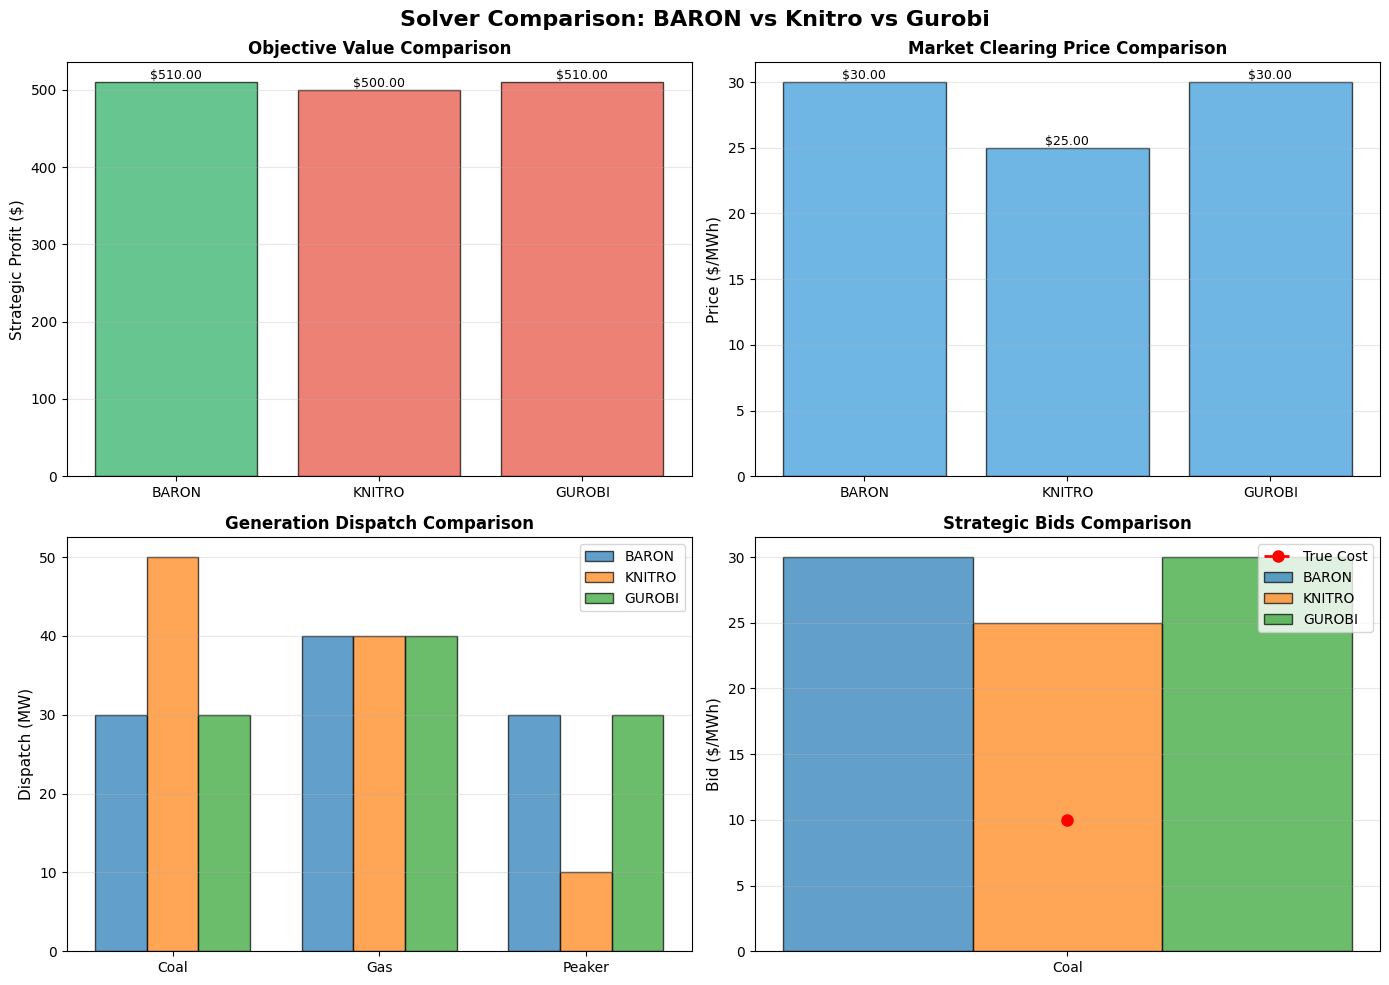

In [8]:
print("\n" + "=" * 70)
print("BILEVEL ELECTRICITY MARKET: SOLVER COMPARISON")
print("=" * 70)
print("\nThis analysis compares three solvers:")
print("  • BARON (Global solver)")
print("  • Knitro (Local MPEC solver)")
print("  • Gurobi (NLP solver, MP transforms complementarity)")
print("\n" + "=" * 70)

# Part 1: Single-point comparison at demand = 100 MW
print("\n\nPART 1: Single Demand Point Comparison")
print("=" * 70)
solutions, comparison_df, gen_data = solve_with_all_solvers()

In [9]:
# Part 2: Sensitivity analysis across demand range
print("\n\nPART 2: Sensitivity Analysis Across Demand Range")
print("=" * 70)
all_results, gen_data = sensitivity_analysis_all_solvers(
    demand_range=range(60, 121, 10)
)

	Nonsquare complementarity system:
		17 complementarities including 11 equations
		18 variables




PART 2: Sensitivity Analysis Across Demand Range

SENSITIVITY ANALYSIS: VARYING DEMAND
Testing demand levels: [60, 70, 80, 90, 100, 110, 120]


Running sensitivity analysis with BARON...
BARON 25.8.5 (2025.08.05): outlev=0
BARON 25.8.5 (2025.08.05): 1 iterations, optimal within tolerances.
Objective 260


	Nonsquare complementarity system:
		17 complementarities including 11 equations
		18 variables


  Demand=60MW: Profit=$260.00, Price=$25.00/MWh, Bid=$25.00/MWh
BARON 25.8.5 (2025.08.05): outlev=0
BARON 25.8.5 (2025.08.05): 1 iterations, optimal within tolerances.
Objective 360


	Nonsquare complementarity system:
		15 complementarities including 10 equations
		16 variables


  Demand=70MW: Profit=$360.00, Price=$25.00/MWh, Bid=$25.00/MWh
BARON 25.8.5 (2025.08.05): outlev=0
BARON 25.8.5 (2025.08.05): 1 iterations, optimal within tolerances.
Objective 440


	Nonsquare complementarity system:
		13 complementarities including 9 equations
		14 variables


  Demand=80MW: Profit=$440.00, Price=$25.00/MWh, Bid=$25.00/MWh
BARON 25.8.5 (2025.08.05): outlev=0
BARON 25.8.5 (2025.08.05): 1 iterations, optimal within tolerances.
Objective 500


	Nonsquare complementarity system:
		9 complementarities including 7 equations
		11 variables


  Demand=90MW: Profit=$500.00, Price=$25.00/MWh, Bid=$24.93/MWh
BARON 25.8.5 (2025.08.05): outlev=0
BARON 25.8.5 (2025.08.05): 1 iterations, optimal within tolerances.
Objective 510.0000001


	Nonsquare complementarity system:
		9 complementarities including 7 equations
		11 variables


  Demand=100MW: Profit=$510.00, Price=$30.00/MWh, Bid=$30.00/MWh
BARON 25.8.5 (2025.08.05): outlev=0
BARON 25.8.5 (2025.08.05): 1 iterations, optimal within tolerances.
Objective 640.0000002


	Nonsquare complementarity system:
		4 complementarities including 4 equations
		9 variables


  Demand=110MW: Profit=$640.00, Price=$30.00/MWh, Bid=$30.00/MWh
BARON 25.8.5 (2025.08.05): outlev=0
BARON 25.8.5 (2025.08.05): 0 iterations, optimal within tolerances.
Objective 750


	Nonsquare complementarity system:
		17 complementarities including 11 equations
		18 variables


  Demand=120MW: Profit=$750.00, Price=$30.00/MWh, Bid=$30.00/MWh

Running sensitivity analysis with KNITRO...
Artelys Knitro 15.0.1: outlev=0
Knitro 15.0.1: Locally optimal or satisfactory solution.
objective 62.50000001; feasibility error 7.61e-10
10 iterations; 15 function evaluations


	Nonsquare complementarity system:
		17 complementarities including 11 equations
		18 variables


  Demand=60MW: Profit=$62.50, Price=$15.00/MWh, Bid=$15.00/MWh
Artelys Knitro 15.0.1: outlev=0
Knitro 15.0.1: Locally optimal or satisfactory solution.
objective 359.9997106; feasibility error 4.8e-06
12 iterations; 17 function evaluations


	Nonsquare complementarity system:
		15 complementarities including 10 equations
		16 variables


  Demand=70MW: Profit=$360.00, Price=$25.00/MWh, Bid=$25.00/MWh
Artelys Knitro 15.0.1: outlev=0
Knitro 15.0.1: Locally optimal or satisfactory solution.
objective 440; feasibility error 1.92e-11
22 iterations; 27 function evaluations


	Nonsquare complementarity system:
		13 complementarities including 9 equations
		14 variables


  Demand=80MW: Profit=$440.00, Price=$25.00/MWh, Bid=$25.00/MWh
Artelys Knitro 15.0.1: outlev=0
Knitro 15.0.1: Locally optimal or satisfactory solution.
objective 499.9999996; feasibility error 4.87e-08
12 iterations; 18 function evaluations


	Nonsquare complementarity system:
		9 complementarities including 7 equations
		11 variables


  Demand=90MW: Profit=$500.00, Price=$25.00/MWh, Bid=$25.00/MWh
Artelys Knitro 15.0.1: outlev=0
Knitro 15.0.1: Locally optimal or satisfactory solution.
objective 500; feasibility error 2.78e-09
7 iterations; 12 function evaluations


	Nonsquare complementarity system:
		9 complementarities including 7 equations
		11 variables


  Demand=100MW: Profit=$500.00, Price=$25.00/MWh, Bid=$24.99/MWh
Artelys Knitro 15.0.1: outlev=0
Knitro 15.0.1: Locally optimal or satisfactory solution.
objective 499.9999535; feasibility error 9.3e-06
6 iterations; 11 function evaluations


	Nonsquare complementarity system:
		4 complementarities including 4 equations
		9 variables


  Demand=110MW: Profit=$500.00, Price=$25.00/MWh, Bid=$24.98/MWh
Artelys Knitro 15.0.1: outlev=0
Knitro 15.0.1: Locally optimal or satisfactory solution.
objective 749.9999729; feasibility error 3.55e-15
5 iterations; 0 function evaluations


	Nonsquare complementarity system:
		17 complementarities including 11 equations
		18 variables


  Demand=120MW: Profit=$750.00, Price=$30.00/MWh, Bid=$20.70/MWh

Running sensitivity analysis with GUROBI...
Gurobi 12.0.3:   tech:outlev = 0
Gurobi 12.0.3: optimal solution; objective 260
7 simplex iterations
1 branching node
absmipgap=0.00874243, relmipgap=3.36247e-05


	Nonsquare complementarity system:
		17 complementarities including 11 equations
		18 variables


  Demand=60MW: Profit=$260.00, Price=$25.00/MWh, Bid=$25.00/MWh
Gurobi 12.0.3:   tech:outlev = 0
Gurobi 12.0.3: optimal solution; objective 360
12 simplex iterations
1 branching node


	Nonsquare complementarity system:
		15 complementarities including 10 equations
		16 variables


  Demand=70MW: Profit=$360.00, Price=$25.00/MWh, Bid=$25.00/MWh
Gurobi 12.0.3:   tech:outlev = 0
Gurobi 12.0.3: optimal solution; objective 440
13 simplex iterations
1 branching node


	Nonsquare complementarity system:
		13 complementarities including 9 equations
		14 variables


  Demand=80MW: Profit=$440.00, Price=$25.00/MWh, Bid=$25.00/MWh
Gurobi 12.0.3:   tech:outlev = 0
Gurobi 12.0.3: optimal solution; objective 500
3 simplex iterations
1 branching node


	Nonsquare complementarity system:
		9 complementarities including 7 equations
		11 variables


  Demand=90MW: Profit=$500.00, Price=$25.00/MWh, Bid=$25.00/MWh
Gurobi 12.0.3:   tech:outlev = 0
Gurobi 12.0.3: optimal solution; objective 510
6 simplex iterations
1 branching node


	Nonsquare complementarity system:
		9 complementarities including 7 equations
		11 variables


  Demand=100MW: Profit=$510.00, Price=$30.00/MWh, Bid=$30.00/MWh
Gurobi 12.0.3:   tech:outlev = 0
Gurobi 12.0.3: optimal solution; objective 640
3 simplex iterations
1 branching node
  Demand=110MW: Profit=$640.00, Price=$30.00/MWh, Bid=$30.00/MWh


	Nonsquare complementarity system:
		4 complementarities including 4 equations
		9 variables


Gurobi 12.0.3:   tech:outlev = 0
Gurobi 12.0.3: optimal solution; objective 750
0 simplex iterations
  Demand=120MW: Profit=$750.00, Price=$30.00/MWh, Bid=$10.00/MWh



Sensitivity analysis visualization saved to 'sensitivity_analysis_comparison.png'



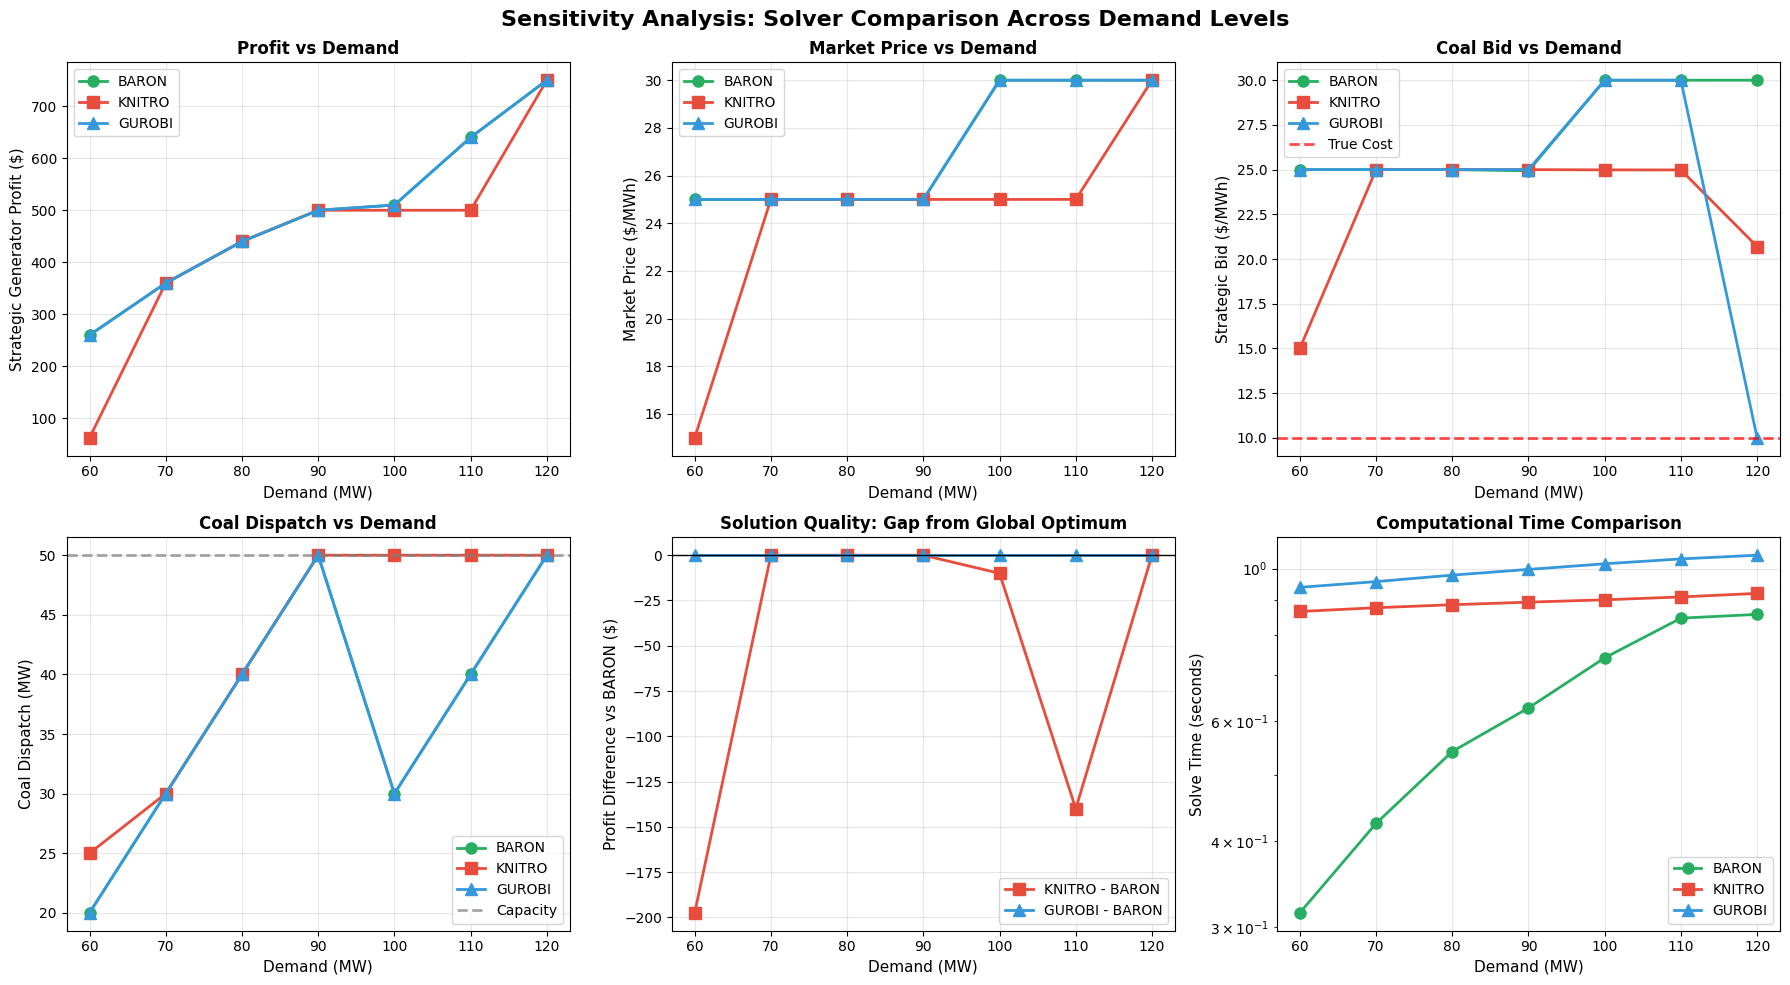


SENSITIVITY ANALYSIS SUMMARY

Checking for local optima across demand range...

Demand = 60 MW:
  BARON   : $  260.00    Gap: $0.00
  KNITRO  : $   62.50    Gap: $197.50
  GUROBI  : $  260.00  ✓ BEST

Demand = 100 MW:
  BARON   : $  510.00  ✓ BEST
  KNITRO  : $  500.00    Gap: $10.00
  GUROBI  : $  510.00    Gap: $0.00

Demand = 110 MW:
  BARON   : $  640.00  ✓ BEST
  KNITRO  : $  500.00    Gap: $140.00
  GUROBI  : $  640.00    Gap: $0.00

MAXIMUM DIFFERENCE: $197.50 at demand = 60 MW

This confirms that local solvers can find different solutions
depending on the problem instance (demand level).

SUMMARY STATISTICS

BARON:
  Average profit: $494.29
  Average solve time: 0.622s
  Total solve time: 4.352s

KNITRO:
  Average profit: $444.64
  Average solve time: 0.893s
  Total solve time: 6.251s

GUROBI:
  Average profit: $494.29
  Average solve time: 0.995s
  Total solve time: 6.967s


ANALYSIS COMPLETE

Generated files:
  • solver_comparison.png
  • sensitivity_analysis_comparison.png


In [10]:
# Visualize sensitivity results
visualize_sensitivity_comparison(all_results, gen_data)

# Analyze sensitivity results
analyze_sensitivity_results(all_results)

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)
print("\nGenerated files:")
print("  • solver_comparison.png")
print("  • sensitivity_analysis_comparison.png")

## Understanding the Optimization Landscape: Why Solvers Differ at Certain Demand Levels

This sensitivity analysis reveals a fundamental characteristic of bilevel electricity market problems: **the optimization landscape changes dramatically across different demand levels**, creating regions where local and global solvers behave very differently.

---

### Executive Summary of Results

| Demand Range | BARON (Global) | Knitro (Local) | Gap | Interpretation |
|-------------|----------------|----------------|-----|----------------|
| 60 MW | \$260 | \$62.50 | \$197.50 | Multiple local optima |
| 70-90 MW | \$360-500 | \$360-500 | \$0 | Unique global optimum |
| 100-110 MW | \$510-640 | \$500 | \$10-140 | Regime transition creates local trap |
| 120 MW | \$750 | \$750 | $0 | Degenerate case (infinite optima) |

---

### The Four Market Regimes

#### Regime 1: Low Demand (60 MW) - Multiple Local Optima

**Market Structure:**
- Total demand = 60 MW
- Expected dispatch: Coal (50 MW) + Gas (10 MW)
- Peaker: OFF

**Why Multiple Optima Exist:**

At low demand, Coal faces a **non-convex tradeoff**:

1. **Strategy A** (Knitro's trap): Bid low (~\$15/MWh)
   - Compete directly with Gas
   - Low price, minimal profit
   - **Local optimum**: \$62.50 profit

2. **Strategy B** (Global optimum): Bid high (~\$25/MWh)
   - Threaten Peaker entry
   - High price, full dispatch at capacity
   - **Global optimum**: \$260 profit

The complementarity constraints create two "hills" in the profit landscape, and Knitro gets stuck on the lower one.

---

#### Regime 2: Stable Region (70-90 MW) - UNIQUE Optimum

**Market Structure:**
- Coal: Always at capacity (50 MW)
- Gas: Interior dispatch (20-40 MW)
- Peaker: Threatening but not dispatched

**Why All Solvers Agree:**

This is the **"Goldilocks zone"** of the optimization landscape:

```
Optimal Strategy = Bid at \$25/MWh (Peaker's cost)

Why this is unique:
• Bid > \$25 → Peaker enters, Coal loses dispatch
• Bid < \$25 → Leaves money on table
• Bid = \$25 → Maximizes profit while keeping Peaker out
```

**Economic Intuition:**
- Peaker's cost (\$25/MWh) creates a **clear price ceiling**
- Any generator bidding above this gets displaced
- This constraint eliminates ambiguity
- Problem becomes **locally convex** in this regime

**Mathematical Property:**
The (KKT) conditions have a **unique solution** because:
1. The active constraints are unambiguous (Peaker entry threat)
2. The Jacobian has full rank
3. No regime-switching occurs in this range

---

#### Regime 3: Transition Zone (100-110 MW) - The Critical Insight

**This is where the story gets interesting.**

**The Regime Change at 90 → 100 MW:**

At **90 MW**:
- Gas hits capacity (40 MW)
- Peaker still not needed
- Optimal: Bid \$25, Profit $500

At **100 MW**:
- Need 10 MW from Peaker
- **Peaker becomes ACTIVE in dispatch**
- New optimal: Bid \$30, Profit \$510
- But old strategy (\$25 bid) is **still locally optimal**!

**Why Knitro Gets Stuck:**

```
The Optimization Landscape at 100 MW:

Profit
  │
  │     ╱╲                    ╱╲
  │    ╱  ╲                  ╱  ╲
  │   ╱    ╲                ╱    ╲
  │  ╱      ╲              ╱      ╲
  │ ╱  Local ╲            ╱ Global ╲
  │╱   Max    ╲__________╱   Max    ╲
  └─────────────────────────────────────> Coal Bid
     $15    $25              $30    ($/MWh)
            ↑                 ↑
         Knitro            BARON
         (Old regime)      (New regime)
```

**Knitro's Perspective:**
1. Starts from some initialization
2. Follows algorithm to nearest peak
3. Converges to bid = \$25, profit = $500
4. This **satisfies all KKT conditions** locally
5. Small perturbations don't improve profit
6. Algorithm terminates: "Locally optimal solution found"

**The Problem:**
- There's a "valley" between the two peaks
- Moving from \$25 → \$30 requires crossing this valley
- Need **global search** to find the better peak

**BARON's Advantage:**
- Uses branch-and-bound with spatial branching
- Explores both regimes systematically
- Not trapped by local optimal solutions
- Finds the discontinuous improvement

**At 110 MW:**
The gap widens to **\$140** because:
- Global optimum moves to \$640 (more Peaker dispatch = higher profit)
- Local optimum stays stuck at \$500 (old regime)
- The "valley" deepens, making escape even harder

---

#### Regime 4: Capacity Constraint (120 MW) - Degeneracy

**Market Structure:**
- ALL generators at 100% capacity
- Total capacity = demand (120 = 120)
- No dispatch flexibility remaining

**Why Solutions Differ in Bid but Not Profit:**

At capacity, Coal's profit becomes:
```
π = λ·p - c·p - q·p²
π = 30×50 - 10×50 - 0.1×(50)²
π = $750

Notice: The bid variable doesn't appear!
```

**The Bid is Irrelevant:**
- Coal must produce 50 MW regardless of bid
- Market price = \$30/MWh (set by scarcity, not bids)
- Any bid from 10 to 30 dollars/MWh yields same profit

**This Creates Infinite Optimal Solutions:**
- BARON picks: Bid \$30
- Knitro picks: Bid \$20.70
- Gurobi picks: Bid \$10
- All are globally optimal!

This is a **degenerate case** - the capacity constraint eliminates all strategic value of bidding.

---

### Mathematical Explanation: Complementarity and Non-Convexity

**Why Complementarity Creates Multiple Optima:**

The KKT conditions for the lower level include:
```
Stationarity: bid - ν - μ⁻ + μ⁺ = 0
Complementarity: μ⁺·(pmax - p) = 0
                 μ⁻·p = 0
```

The complementarity conditions mean:
```
Either: μ⁺ = 0  OR  p = pmax  (generator at capacity or not)
Either: μ⁻ = 0  OR  p = 0     (generator on or off)
```

This creates **discrete regimes**:
- Regime A: Coal at capacity, Gas interior, Peaker off
- Regime B: Coal at capacity, Gas at capacity, Peaker interior
- Each regime has its own local optimum
- Switching regimes requires discrete jump

**The Feasible Region is Non-Convex:**
```
Feasible set = Union of regime-specific polytopes
             = {(p, μ) : Regime A conditions} ∪ {(p, μ) : Regime B conditions}
```

The union of convex sets is **not convex** → multiple local optima possible.

---

### Economic Interpretation: Market Power and Regime Transitions

**What This Tells Us About Electricity Markets:**

1. **Strategic Bidding is Regime-Dependent**
   - At 70-90 MW: Bid at Peaker cost (\$25)
   - At 100+ MW: Bid at price cap (\$30)
   - Strategy changes discontinuously

2. **Market Power Varies with Load**
   - Low/high demand: Multiple equilibria (strategic complexity)
   - Medium demand: Unique equilibrium (clear constraints)
   - This matches real-world market observations

3. **Transition Points are Critical**
   - When Gas hits capacity (90 MW)
   - When Peaker becomes active (100 MW)
   - These are where market manipulation is most complex

4. **Scarcity Reduces Strategic Value**
   - At 120 MW (full capacity), bidding doesn't matter
   - Price is set by scarcity, not strategy
   - Real markets also see this during peak demand

---
### Key Takeaways for MPEC Problems

1. **Test Across Operating Range**
   - Don't validate on a single point
   - Identify regime transitions
   - Check solver consistency across conditions

2. **Local Optima are Problem-Dependent**
   - 70-90 MW: No local optima (well-behaved)
   - 60, 100-110 MW: Multiple local optima (transitions)
   - Location of optima depends on market structure

3. **Economic Validation is Essential**
   - Does the solution make economic sense?
   - Are generators dispatched in merit order?
   - Does price reflect marginal cost or scarcity?

4. **Complementarity is the Culprit**
   - Creates discrete regimes (on/off, at capacity/interior)
   - Regimes have different local optima
   - Global search needed to compare across regimes

---

### For Further Reading

This phenomenon is well-documented in the literature:

- **Luo, Pang, Ralph (1996)**: "Mathematical Programs with Equilibrium Constraints"
- **Gabriel et al. (2013)**: "Complementarity Modeling in Energy Markets"
- **Fortuny-Amat & McCarl (1981)**: "A Representation and Economic Interpretation of a Two-Level Programming Problem"

The sensitivity analysis presented here provides **empirical evidence** of these theoretical predictions in a realistic electricity market setting.


## Understanding AMPL Complementarity Constraint Syntax

AMPL provides specialized syntax for complementarity constraints that are essential for MPEC formulations. The `complements` operator connects two conditions that must hold in a mutually exclusive way.

---

### Basic Form: Single-Inequality Complements Single-Inequality

The most common form in MPEC problems is:

```ampl
single-inequality complements single-inequality;
```

**Satisfaction Conditions:**
1. Both inequalities must be satisfied
2. **At least one must hold with equality** (i.e., be binding)

**Example from Our Model:**

```ampl
subject to Comp_Lower {i in GENERATORS}:
    mu_lower[i] >= 0 complements p[i] >= 0;
```

**What This Means:**
- Both $\mu_i^- \geq 0$ and $p_i \geq 0$ must be satisfied
- **Additionally:** Either $\mu_i^- = 0$ OR $p_i = 0$ (or both)

This encodes the complementarity condition: $\mu_i^- \cdot p_i = 0$

**Valid Configurations:**

| Case | $\mu_i^-$ | $p_i$ | Interpretation |
|------|-----------|-------|----------------|
| 1 | $= 0$ | $> 0$ | Generator is dispatched, lower bound not binding |
| 2 | $> 0$ | $= 0$ | Generator not dispatched, would cost too much to turn on |
| 3 | $= 0$ | $= 0$ | Degenerate case (both at boundary) |

**Invalid Configuration:**
- Both $\mu_i^- > 0$ AND $p_i > 0$ (both strictly positive violates complementarity)

---

### Double-Inequality Form

A more general form uses a double-sided inequality:

```ampl
double-inequality complements expression;
```

or equivalently:

```ampl
expression complements double-inequality;
```

**Example:**

```ampl
subject to Comp_Upper_Alt {i in GENERATORS}:
    mu_upper[i] complements 0 <= p[i] <= pmax[i];
```

**Satisfaction Conditions:**
- If **left side** of double-inequality is binding ($p_i = 0$), then $\mu_i^+ \geq 0$
- If **right side** of double-inequality is binding ($p_i = \bar{p}_i$), then $\mu_i^+ \leq 0$
- If **neither side** is binding ($0 < p_i < \bar{p}_i$), then $\mu_i^+ = 0$

**Special Case:** When the double-inequality is `0 <= variable <= Infinity`, this reduces to standard complementarity. This is why our model uses:

```ampl
subject to Comp_Upper {i in GENERATORS}:
    mu_upper[i] >= 0 complements pmax[i] - p[i] >= 0;
```

Here, the slack variable is $(pmax[i] - p[i]) \geq 0$, which ensures:
- If $p_i = pmax[i]$ (at capacity), then slack $= 0$, so $\mu_i^+ > 0$ is allowed
- If $p_i < pmax[i]$ (not at capacity), then slack $> 0$, so $\mu_i^+ = 0$ is required

---

### Comparison: Two Ways to Write the Same Constraint

Our model uses the **single-inequality form** for clarity:

```ampl
# What we use (explicit slack variable)
subject to Comp_Upper {i in GENERATORS}:
    mu_upper[i] >= 0 complements pmax[i] - p[i] >= 0;
```

**Alternative using double-inequality form:**

```ampl
# Equivalent formulation
subject to Comp_Upper_Alt {i in GENERATORS}:
    mu_upper[i] complements 0 <= p[i] <= pmax[i];
```

Both are mathematically equivalent, but the first form makes the complementarity relationship more explicit:
$$\mu_i^+ \cdot (\bar{p}_i - p_i) = 0$$

---

### Why This Syntax Matters for MPEC

The `complements` operator tells AMPL to:

1. **Recognize this as a complementarity constraint**, not a regular constraint
2. **Invoke MPEC-capable solvers** (like Knitro with `ms_enable=1`)
3. **Use specialized algorithms** that handle the non-convex, disjunctive nature

**Without `complements`:** If you tried to write this as a regular constraint:

```ampl
# WRONG - This won't work!
subject to Comp_Lower_Wrong {i in GENERATORS}:
    mu_lower[i] * p[i] = 0;  # Ordinary constraint
```

**Problems:**
- Creates a bilinear constraint (non-convex)
- Standard NLP solvers will struggle
- No indication to AMPL that this is complementarity
- May converge to infeasible or suboptimal solutions

**With `complements`:** AMPL passes the problem to Knitro's MPEC mode, which:
- Uses sequential relaxation schemes
- Gradually enforces complementarity
- Handles the regime-switching structure correctly

---

### Practical Tips for Writing Complementarity Constraints

**1. Always Check Variable Bounds Match Complementarity**

```ampl
# Variable declaration
var p {i in GENERATORS} >= 0, <= pmax[i];

# Corresponding complementarity
subject to Comp_Lower {i in GENERATORS}:
    mu_lower[i] >= 0 complements p[i] >= 0;  # ✓ Matches lower bound

subject to Comp_Upper {i in GENERATORS}:
    mu_upper[i] >= 0 complements pmax[i] - p[i] >= 0;  # ✓ Matches upper bound
```

**2. Dual Variables Should Be Free or Non-Negative**

```ampl
var nu;                       # Free (dual of equality)
var mu_lower {GENERATORS} >= 0;  # Non-negative (dual of inequality)
var mu_upper {GENERATORS} >= 0;  # Non-negative (dual of inequality)
```

**3. Use Meaningful Names for Slack Variables**

Instead of:
```ampl
mu_upper[i] >= 0 complements pmax[i] - p[i] >= 0;
```

You could define:
```ampl
var slack_upper {i in GENERATORS} = pmax[i] - p[i];
subject to Comp_Upper {i in GENERATORS}:
    mu_upper[i] >= 0 complements slack_upper[i] >= 0;
```

This makes debugging easier.

**4. Verify Complementarity Numerically**

After solving, always check:

```python
for gen in generators:
    mu_l = ampl.var['mu_lower'][gen].value()
    mu_u = ampl.var['mu_upper'][gen].value()
    p_val = ampl.var['p'][gen].value()
    slack_u = pmax[gen] - p_val
    
    viol_l = abs(mu_l * p_val)
    viol_u = abs(mu_u * slack_u)
    
    if viol_l > 1e-6 or viol_u > 1e-6:
        print(f"WARNING: Complementarity violation for {gen}")
        print(f"  mu_lower * p = {viol_l:.2e}")
        print(f"  mu_upper * slack = {viol_u:.2e}")
```

Small violations ($< 10^{-6}$) are normal due to numerical tolerances.

---

### Summary: Complementarity in Our Electricity Market Model

Our model uses complementarity constraints to encode the KKT conditions of the lower level (ISO's market clearing problem):

| **Mathematical Condition** | **AMPL Syntax** | **Meaning** |
|---------------------------|-----------------|-------------|
| $\mu_i^- \geq 0, \, p_i \geq 0, \, \mu_i^- \cdot p_i = 0$ | `mu_lower[i] >= 0 complements p[i] >= 0` | If generator produces, lower bound not binding |
| $\mu_i^+ \geq 0, \, (\bar{p}_i - p_i) \geq 0, \, \mu_i^+ \cdot (\bar{p}_i - p_i) = 0$ | `mu_upper[i] >= 0 complements pmax[i] - p[i] >= 0` | If not at capacity, upper bound not binding |

These complementarity constraints, combined with:
- Primal feasibility (PowerBalance, variable bounds)
- Stationarity (Stationarity_Strategic, Stationarity_Competitive)
- Price definition (lambda = nu)

...completely characterize the solution to the lower level problem, allowing us to solve the entire bilevel problem as a single-level MPEC.

The `complements` operator is what makes MPEC modeling in AMPL both elegant and computationally tractable. It tells the solver "these two things can't both be strictly positive—handle the regime-switching logic appropriately."